### End to end train both networks

In [1]:
### for cpu training

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
tf_sess = K.get_session()

In [4]:
tf_sess

In [5]:
### Hyperparameters

experiment_id = 0

learning_rate = 0.0001

epochs = [200, 20000, 10000, 4000]
batch_sizes = [1024, 1024, 128, 1024]

lambda_1 = 0.1       
lambda_2 = 0.005     

#################

epoch = epochs[experiment_id]
batch_size = batch_sizes[experiment_id]

### Define compresion network

In [6]:
input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



- Define similarity metrics

In [7]:
def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

In [8]:
layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

In [9]:
layer_cossim

<tf.Tensor 'cos_sim/Reshape:0' shape=(1024, 1) dtype=float32>

In [10]:
layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

In [11]:
layer_relativeEuc

<tf.Tensor 'relative_euc_dist/Reshape:0' shape=(1024, 1) dtype=float32>

- No need to reshape layer_lowdim

In [12]:
layer_lowdim

<tf.Tensor 'lowdim/BiasAdd:0' shape=(1024, 1) dtype=float32>

- Obtain "z"

In [13]:
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])

In [14]:
layer_concat

<tf.Tensor 'z/concat:0' shape=(1024, 3) dtype=float32>

### Define estimation network

In [15]:
input_est = layer_concat #Input(shape=(3,))(layer_concat)

est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
est_layer = Dropout(0.5)(est_layer)
est_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='gamma')(est_layer)


### Build full network

In [16]:
full_network = Model(input=input_data, outputs=est_output)

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ga..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [17]:
full_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1024, 120)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1024, 60)           7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1024, 30)           1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1024, 10)           310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

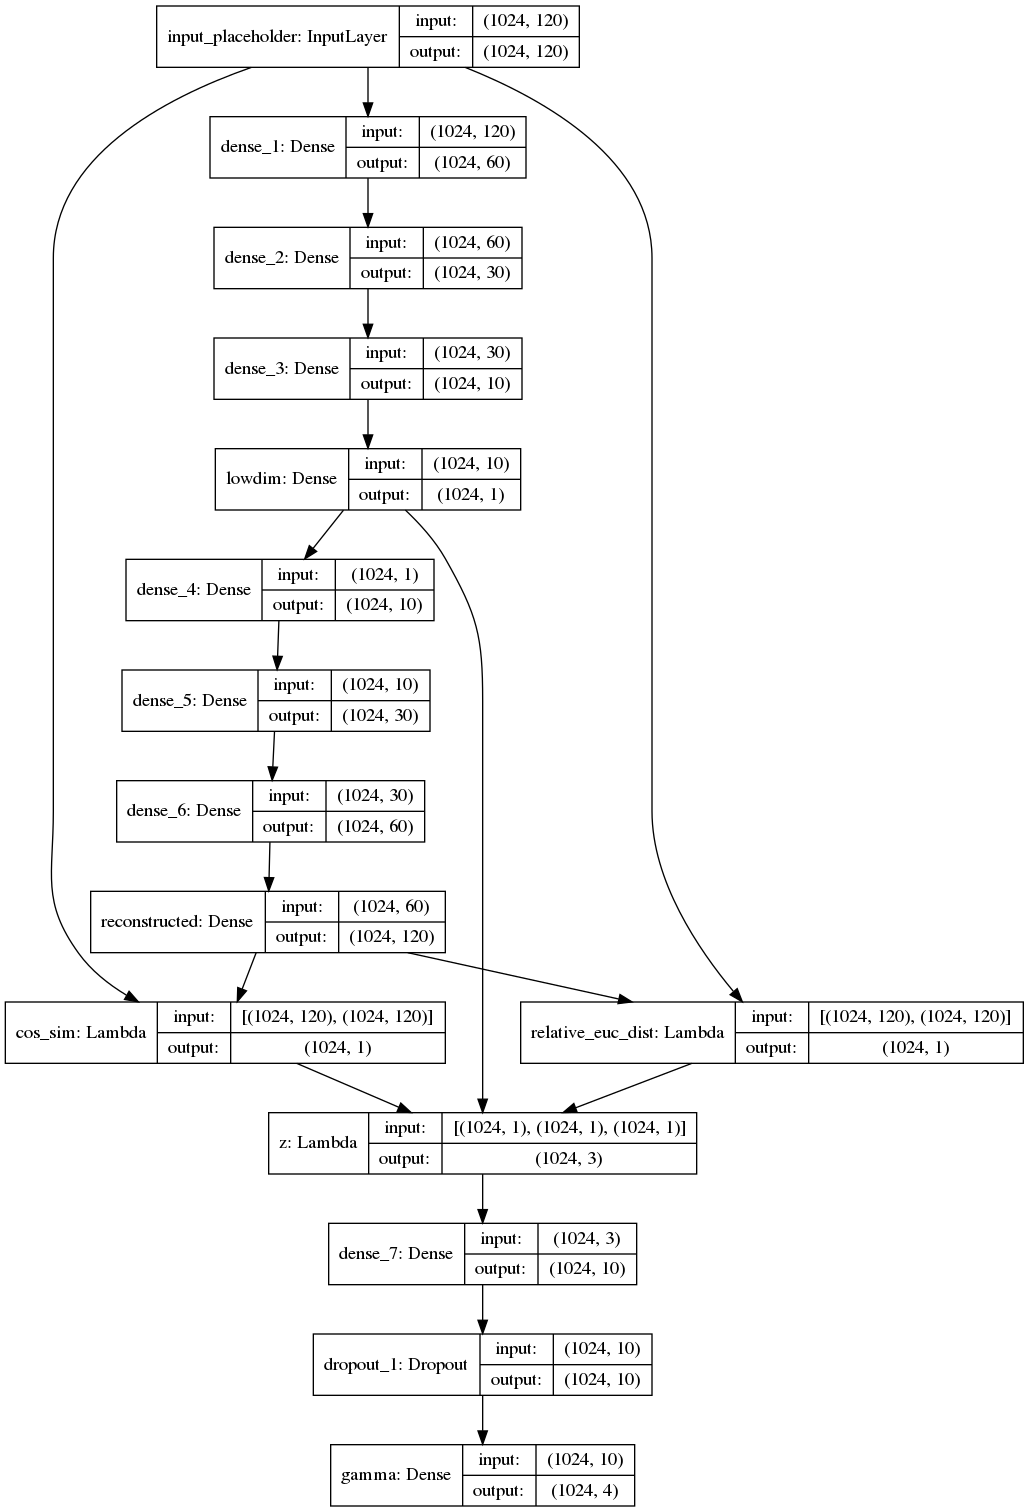

In [18]:
### model visualization
from keras.utils import plot_model


model = full_network

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### Load already saved dataset

In [19]:
import numpy as np

In [20]:
with np.load('kdd99_train_test.npz') as data:
    x_train = data['x_train']     
    x_test = data['x_test']
    x_all = np.concatenate([x_train, x_test], axis=0)

In [21]:
x_all.shape

(494021, 120)

- Get only the normal data

In [22]:
normal_data = x_all[np.where(x_all[:,-1] == 1)]   ##last column is the normal column

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(normal_data, test_size=0.5, random_state=42)

In [24]:
x_train.shape

(48639, 120)

In [25]:
x_test.shape

(48639, 120)

- Assign arbitrary output (assuming first column is normal)

In [26]:
y_train = np.zeros((len(x_train),4))

y_train[:,0] = 1

In [27]:
y_train.shape

(48639, 4)

### GMM parameters

- k: number of clusters (4 for here)
- N: batch size
- d: Dimension of latent vector z (3 here)

- gamma ($\gamma$) : membership predictions (softmax output of estimation net) [$N \times K$]
- phi ($\phi$): gaussian probabilities [$K$]
- mu ($\mu$): gaussian means [$K \times d$]
- sigma ($\Sigma$): gaussian covariances [$K \times d \times d$]

In [28]:
k = 4 
N = batch_size 
d = int(layer_concat.get_shape()[1])

- GMM parameters init

In [29]:
sigma_init = np.eye(d, dtype=np.float32)   ##np.repeat([np.eye(d, dtype=np.float32)],k, axis=0)

In [30]:
sigma_init

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [31]:
phi = tf.get_variable("phi",
                      shape=(k),
                      dtype=tf.float32,
                      initializer=tf.zeros_initializer(),
                      trainable=False)

mu = tf.get_variable("mu",
                      shape=(k,d),
                      dtype=tf.float32,
                      initializer=tf.zeros_initializer(), 
                      trainable=False)


### quick workaround for slice problem
sigma = []
for i in range(k):
    sigma.append(tf.get_variable("sigma"+str(i),
                                  shape=(d,d),
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(sigma_init), ###tf.ones_initializer(),
                                  trainable=False))
                  
                  

In [32]:
tf_sess.run([phi.initializer,
             mu.initializer])

for s in sigma:
    tf_sess.run([s.initializer])
    
    
#tf_sess.run(phi.initializer)
#tf_sess.run(mu.initializer)
#tf_sess.run(sigma.initializer)

- Check for uninit vars

In [33]:
print(tf_sess.run(tf.report_uninitialized_variables()))

[b'dense_1/kernel' b'dense_1/bias' b'dense_2/kernel' b'dense_2/bias'
 b'dense_3/kernel' b'dense_3/bias' b'lowdim/kernel' b'lowdim/bias'
 b'dense_4/kernel' b'dense_4/bias' b'dense_5/kernel' b'dense_5/bias'
 b'dense_6/kernel' b'dense_6/bias' b'reconstructed/kernel'
 b'reconstructed/bias' b'dense_7/kernel' b'dense_7/bias' b'gamma/kernel'
 b'gamma/bias']


In [34]:
def printGmmParams():
    print("#### GMM params ####")
#    print("---shapes---")
#    print("phi:\n",phi.shape)
#    print("mu:\n",mu.shape)
#    print("sigma:\n",sigma[0].shape)   
#    print("")
    
#    print("---values---")
    print("phi:\n",K.eval(phi),"\n")
    print("mu:\n",K.eval(mu),"\n")
    print("sigma:")
    for s in sigma:
        print(K.eval(s),"\n")


In [35]:
printGmmParams()

#### GMM params ####
phi:
 [0. 0. 0. 0.] 

mu:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 

sigma:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 



### Total loss calculation

In [36]:
isVerbose_en = True
isVerbose_loss = True

- For the first time run of the totalLoss function

In [37]:
choices = np.random.choice(len(x_train), size=batch_size, replace=False)

batch_x_train = x_train[choices]
batch_y_train = y_train[choices]

batch_train = (batch_x_train, batch_y_train)

- Define energy function

In [38]:
def computeEnergy(z_i):
    """
    compute E(z_i) in loss function
    """
    
    #inside_sum = 0
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_init, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))

        inside_sum += phi[cluster] * (exp_term / denom) 
        
    inside_sum += 1e-6    ### for numerical stability
                
    global isVerbose_en
    if isVerbose_en:
        print("---computeEnergy---")
        print("---shapes:")
        print("diff:",diff.shape)
        print("diff_t:",diff_t.shape)
        print("sigma_inv:",sigma_inv.shape)
        print("exp_term:", exp_term.shape)
        print("denom:", denom.shape)
        print("inside_sum:", inside_sum.shape)
        print("---values:")
        print("diff:\n",diff)
        print("diff_t:\n",diff_t)
        print("sigma_inv:\n",sigma_inv)
        print("exp_term:\n", exp_term)
        print("denom:\n", denom)
        print("inside_sum:\n", inside_sum)
        print("")
        
        isVerbose_en = False
        
    ### flatten inside_sum and return log of it
    return -tf.log(tf.reshape(inside_sum, ()))

- Define total loss

In [39]:
def totalLoss(yTrue, yPred):
    ### autoencoder loss
    autoenc_loss = tf.sqrt((input_data - decoded)**2)
    autoenc_loss = tf.reduce_mean(autoenc_loss)     
    
    ### obtain z for current batch
    z = layer_concat
    
    
    ### dependency control
    is_updates_gmm = tf.get_default_graph().get_operation_by_name("updates_gmm")    
    with tf.control_dependencies([is_updates_gmm]):  
        ### sample energy   
        sample_en_batch = tf.map_fn(lambda z_i: computeEnergy(z_i), z)
        sample_en = tf.reduce_mean(sample_en_batch, axis=0)
        sample_en *= lambda_1


        ### diagonal regularization
        p = tf.zeros(())
        for cluster in range(k):
            diagonal = 1 / tf.matrix_diag_part(sigma[cluster])
            p += tf.reduce_sum(diagonal)

        p *= lambda_2


        ### total loss
        total_loss = autoenc_loss + sample_en + p
    
    ### print
    global isVerbose_loss
    if isVerbose_loss:
        print("---totalLoss---")
        print("autoenc_loss:\n", autoenc_loss)
        print("sample_en:\n", sample_en)
        print("p:\n", p)
        print("total_loss:\n", total_loss)
        isVerbose_loss = False

    return total_loss    

- Calculate GMM parameters after each batch

In [40]:
class CallbackComputeGMM(Callback):
    def on_batch_end(self, batch, logs={}): 
    
        gamma = est_output 
        z = layer_concat         

        ### update list
        updates_gmm = []
        
        ################### phi #################
        update_phi = tf.assign(phi, 
                               tf.reduce_sum(gamma/batch_size, axis=0), 
                               name="update_phi")
        updates_gmm.append(update_phi)
                #######################################
        
        ################## mu ################
        for cluster in range(k):
            ### get the corresponding column of predictions
            gamma_cluster = tf.reshape(gamma[:,cluster], (-1,1))    ### (N x 1)
            
            ### duplicate column d times
            gamma_cluster_tile = tf.tile(gamma_cluster, (1,d))   ### (N x d)

            ### sum over all batch and divide
            matmul = tf.matmul(z, gamma_cluster_tile, transpose_a=True)   ### (dxd)
            
            result = tf.reduce_sum(matmul, axis=0, name="mu_matmul_red") / tf.reduce_sum(gamma[:,cluster], axis = 0, name="mu_gamma_red")
            
            update_mu = tf.assign(mu[cluster], 
                                  result,
                                  name="update_mu"+str(cluster))
            updates_gmm.append(update_mu)
        #########################################
        
        ################ sigma ###############
        for cluster in range(k):
            ### expand gamma for each sample
            gamma_cluster = tf.reshape(gamma[:,cluster], (-1,1))    ### (N x 1)
            gamma_cluster_expand = tf.expand_dims(gamma_cluster, 1) ### (N x 1 x 1)

            
            #### calculating diff
            ## expand mu and z
            ######## TODO: race condition??? (get mu after its updated value (auto??))
            with tf.control_dependencies(updates_gmm):
                mu_cluster = tf.reshape(mu[cluster], (1,-1))   ### (1 x d)
                
            mu_expand = tf.expand_dims(mu_cluster, 1)      ### (1 x 1 x 3)
            mu_expand_tile = tf.tile(mu_expand, tf.stack([N, 1, 1]))   ### (N x 1 x d)

            z_expand = tf.expand_dims(z, 1)    ### (N x 1 x d)

            diff = z_expand - mu_expand_tile   ### (N x 1 x d)

            ### matmul in the upper part
            matmul = tf.matmul(diff, diff, transpose_a=True)  ### (N x d x d)
            

            ### nominator
            nom = gamma_cluster_expand * matmul   ### (N x d x d)
            nom_reduced = tf.reduce_sum(nom, axis=0) ### (d x d)

            
            ### denominator
            denom = tf.reduce_sum(gamma_cluster)  ### single value, zero dim
                 
            update_sigma = tf.assign(sigma[cluster], 
                                     nom_reduced/denom, 
                                     name ="update_sigma"+str(cluster))
            updates_gmm.append(update_sigma)
            
        
        #######################################      
        tf.group(updates_gmm, name="updates_gmm")
        
                                           
        return

- Compile model

In [41]:
compute_gmm = CallbackComputeGMM()

- For the first time run (otherwise updates_gmm is uninitialized in totalLoss)

In [42]:
compute_gmm.on_batch_end(batch_train)

In [43]:
adam = optimizers.adam(lr=learning_rate, clipnorm=1., clipvalue=0.5) 

full_network.compile(optimizer=adam, loss=totalLoss) 

---computeEnergy---
---shapes:
diff: (1, 3)
diff_t: (3, 1)
sigma_inv: (3, 3)
exp_term: (1, 1)
denom: ()
inside_sum: (1, 1)
---values:
diff:
 Tensor("loss/gamma_loss/map/while/Reshape_6:0", shape=(1, 3), dtype=float32)
diff_t:
 Tensor("loss/gamma_loss/map/while/Reshape_7:0", shape=(3, 1), dtype=float32)
sigma_inv:
 Tensor("loss/gamma_loss/map/while/MatrixInverse_3:0", shape=(3, 3), dtype=float32)
exp_term:
 Tensor("loss/gamma_loss/map/while/Exp_3:0", shape=(1, 1), dtype=float32)
denom:
 Tensor("loss/gamma_loss/map/while/Sqrt_3:0", shape=(), dtype=float32)
inside_sum:
 Tensor("loss/gamma_loss/map/while/add_4:0", shape=(1, 1), dtype=float32)

---totalLoss---
autoenc_loss:
 Tensor("loss/gamma_loss/Mean:0", shape=(), dtype=float32)
sample_en:
 Tensor("loss/gamma_loss/mul:0", shape=(), dtype=float32)
p:
 Tensor("loss/gamma_loss/mul_1:0", shape=(), dtype=float32)
total_loss:
 Tensor("loss/gamma_loss/add_5:0", shape=(), dtype=float32)


- Batch generator for training

In [44]:
def batchGenerator():
    '''
    return: number of batch_size examples in each run
    '''

    #global batch_train
    
    while True:
        choices = np.random.choice(len(x_train), size=batch_size, replace=False)
        
        batch_x_train = x_train[choices]
        batch_y_train = y_train[choices]
        
        batch_train = (batch_x_train, batch_y_train)
        
        
        yield batch_train 

In [45]:
from keras.callbacks import TerminateOnNaN

terminate_onNan = TerminateOnNaN()

- Alternative training: step by step and print gmm params

In [46]:
total = 100

for step in range(total):
    print("\x1b[91m\x1b[1m","step:",step,"of",total, "\x1b[0m")
    
    printGmmParams()
                 
    history = full_network.fit_generator(batchGenerator(),
                               epochs = 1,  #epoch,
                               steps_per_epoch = 1, #48, #steps_per_epoch,
                               callbacks = [compute_gmm, terminate_onNan], # , tensorboard],
                               verbose = 1)
    
    print("")
    
    print("\x1b[90m\x1b[1m", "-"*70, "\x1b[0m", "\n")
    
    if str(history.history["loss"][0]) == "nan":
        printGmmParams()
        break
    

 step: 0 of 100 
#### GMM params ####
phi:
 [0. 0. 0. 0.] 

mu:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 

sigma:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 4.5391

 ----------------------------------------------------------------------  

 step: 1 of 100 
#### GMM params ####
phi:
 [0.2279111  0.302637   0.2556029  0.21384941] 

mu:
 [[1.0886246 1.0886246 1.0886246]
 [1.104076  1.104076  1.104076 ]
 [1.0884962 1.0884962 1.0884962]
 [1.0969477 1.0969477 1.0969477]] 

sigma:
[[0.9225491  1.0980028  0.05595803]
 [1.0980028  1.4020761  0.06385902]
 [0.05595803 0.06385902 0.0038728 ]] 

[[0.9151725  1.1149403  0.06842059]
 [1.1149403  1.4505646  0.08083976]
 [0.06842059 0.08083976 0.00554731]] 

[[0.9319672  1.0973079  0.05657048]
 [1.0973079  1.3930256  0.06358521]
 [0.05657048 0.06358521 0.00392089]] 

1/1 [==============================] - 0s 295ms/step - loss: 0.7947

 ----------------------------------------------------------------------  

 step: 11 of 100 
#### GMM params ####
phi:
 [0.21744278 0.29434285 0.27662912 0.2115856 ] 

mu:
 [[1.1678919 1.1678919 1.1678919]
 [1.1767871 1.1767871 1.1767871]
 [1.1793965 1.1793965 1.1793965]
 [1.1781522 1.1781522 1.1781522]] 

sigma:
[[1.2084123  1.169496   0.16909431]
 [1.169496   1.2636477  0.16520236]
 [0.16909431 0.16520236 0.02399399]] 

[[1.2094544  1.1790153  0.1787428 ]
 [1.1790153  1.2824507  0.1759831 ]
 [0.1787428  0.1759831  0.02673769]] 

[[1.2581689  1.1806184  0.18662363]
 [1.1806184  1.2432414  0.17710032]
 [0.18662363 0.17710032 0.02809178]] 

[[1.2234848  1.1803858  0.18112633]
 [1.1803858  1.2748321  0.17659478]
 [0.18112633 0.17659478 0.02718309]] 

Epoch 1/1
1/1 [==============================] - 0s 363ms/step - loss: 0.7226

 ----------------------------------------------------------------------  

 step: 12 of 100 


1/1 [==============================] - 0s 345ms/step - loss: 0.3942

 ----------------------------------------------------------------------  

 step: 21 of 100 
#### GMM params ####
phi:
 [0.21531415 0.2942098  0.27885196 0.2116242 ] 

mu:
 [[1.2405703 1.2405703 1.2405703]
 [1.2642183 1.2642183 1.2642183]
 [1.2721477 1.2721477 1.2721477]
 [1.2567079 1.2567079 1.2567079]] 

sigma:
[[1.3666822  1.2418698  0.27202484]
 [1.2418698  1.2744321  0.2512314 ]
 [0.27202484 0.2512314  0.05477244]] 

[[1.4054548  1.2658132  0.30440316]
 [1.2658132  1.2966118  0.2784908 ]
 [0.30440316 0.2784908  0.06651445]] 

[[1.4603966  1.2724335  0.3211954 ]
 [1.2724335  1.2673153  0.28422034]
 [0.3211954  0.28422034 0.07131169]] 

[[1.395199   1.2581453  0.29420894]
 [1.2581453  1.2884282  0.26960137]
 [0.29420894 0.26960137 0.06265903]] 

Epoch 1/1
1/1 [==============================] - 0s 302ms/step - loss: 0.3600

 ----------------------------------------------------------------------  

 step: 22 of 100 


1/1 [==============================] - 0s 356ms/step - loss: 0.2800

 ----------------------------------------------------------------------  

 step: 31 of 100 
#### GMM params ####
phi:
 [0.21290983 0.29432443 0.27947396 0.2132917 ] 

mu:
 [[1.312612  1.312612  1.312612 ]
 [1.3328302 1.3328302 1.3328302]
 [1.3467215 1.3467215 1.3467215]
 [1.3307205 1.3307205 1.3307205]] 

sigma:
[[1.5104539  1.3130343  0.38199222]
 [1.3130343  1.2994425  0.33731338]
 [0.38199222 0.33731338 0.09732682]] 

[[1.563548   1.3329663  0.4147492 ]
 [1.3329663  1.3024278  0.35917172]
 [0.4147492  0.35917172 0.11072473]] 

[[1.6207428  1.3460972  0.44065574]
 [1.3460972  1.2888882  0.3717847 ]
 [0.44065574 0.3717847  0.12062054]] 

[[1.5522261  1.3311386  0.41021934]
 [1.3311386  1.3085898  0.35744196]
 [0.41021934 0.35744196 0.10913281]] 

Epoch 1/1
1/1 [==============================] - 0s 295ms/step - loss: 0.2582

 ----------------------------------------------------------------------  

 step: 32 of 100 


In [47]:
history.history

{'loss': [nan]}

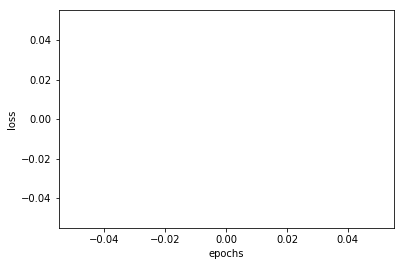

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_historyData(data, xlabel="epochs", ylabel="loss"):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
plot_historyData(history.history["loss"])